In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
import pandas as pd
import pickle
import seaborn as sns
from NLPUtils.DataModel import Vocabulary
import matplotlib.pyplot as plt

c:\Users\Wen2Tee5\Desktop\Postgraduate\torchPlayGround\torchEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('./NLPUtils/pretrain/glove.6B/glove.6B.300d.data', 'rb') as f:
    Word2Embedding = pickle.load(f)
with open('./SLTCDataset/mr/train_voc.data', 'rb') as f:
    train_voc = pickle.load(f)
# 必須確定為有序
embeddingMatrix = []
for data in train_voc.word2idx:
    if data == "<UNK>":
        embeddingMatrix.append(np.zeros(shape=(300)))
    else:
        if data in Word2Embedding :
            embeddingMatrix.append(Word2Embedding[data])
        else:
            embeddingMatrix.append(np.random.uniform(low = 0., high = 1., size=300))
embeddingMatrix = np.array(embeddingMatrix, np.float32)
assert train_voc.num_words == len(embeddingMatrix)

In [3]:
x_train = np.load('./SLTCDataset/mr/x_train.npy')
y_train = np.load('./SLTCDataset/mr/y_train.npy')
x_test = np.load('./SLTCDataset/mr/x_test.npy')
y_test = np.load('./SLTCDataset/mr/y_test.npy')
trainDataset = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
testDataset = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))
trainDataLoader = DataLoader(trainDataset, batch_size = 32, shuffle=True)

In [4]:
it = iter(trainDataLoader)
bat_x, bat_y = next(it)

In [5]:
class Emb_MLP(torch.nn.Module):

    def __init__(self, train_voc : Vocabulary, preTrainedEmb : np.ndarray, freeze = True) -> None:
        super(Emb_MLP, self).__init__()
        self.embedd = torch.nn.EmbeddingBag(train_voc.num_words, preTrainedEmb.shape[1]).from_pretrained(
            embeddings=torch.from_numpy(preTrainedEmb).type(torch.float32),
            freeze = freeze,
            padding_idx=0
            )
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(300, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 2)
        )
    def forward(self, x):
        h = self.embedd(x)
        out = self.mlp(h)
        return out

In [6]:
emb_mlp = Emb_MLP(train_voc=train_voc, preTrainedEmb=embeddingMatrix).cuda()
loss_fn = torch.nn.CrossEntropyLoss()
otim = torch.optim.Adam(emb_mlp.parameters())
losses = []

In [7]:
for ep in tqdm(range(20)):
    total_loss = 0.
    for x, y in trainDataLoader:
        x, y = x.cuda(), y.cuda()
        otim.zero_grad()
        pred = emb_mlp(x)
        loss = loss_fn(pred, y)
        loss.backward()
        otim.step()
        total_loss += loss.item()
    losses.append(total_loss / (len(testDataset) / 32))

100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


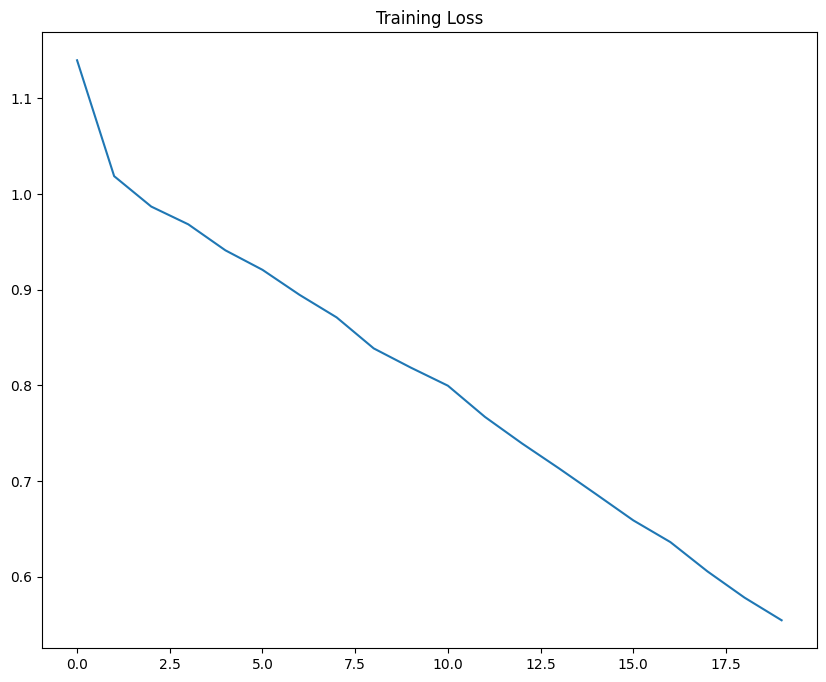

In [8]:
plt.figure(figsize=(10, 8))
plt.plot(losses)
plt.title("Training Loss")
plt.show()

In [9]:
with torch.no_grad():
    x, y = testDataset.tensors[0].cuda(), testDataset.tensors[1].cuda()
    pred = emb_mlp(x)
    count = (pred.argmax(1) == y).sum().float()
    print(f'Acc = {count / len(testDataset) * 100 : 0.3f}%')

Acc =  72.988%


In [10]:
emb_mlp_unfreeze = Emb_MLP(train_voc=train_voc, preTrainedEmb=embeddingMatrix, freeze = False).cuda()
loss_fn = torch.nn.CrossEntropyLoss()
otim = torch.optim.Adam(emb_mlp_unfreeze.parameters())
losses = []

In [11]:
for ep in tqdm(range(20)):
    total_loss = 0.
    for x, y in trainDataLoader:
        x, y = x.cuda(), y.cuda()
        otim.zero_grad()
        pred = emb_mlp_unfreeze(x)
        loss = loss_fn(pred, y)
        loss.backward()
        otim.step()
        total_loss += loss.item()
    losses.append(total_loss / (len(testDataset) / 32))

100%|██████████| 20/20 [00:08<00:00,  2.33it/s]


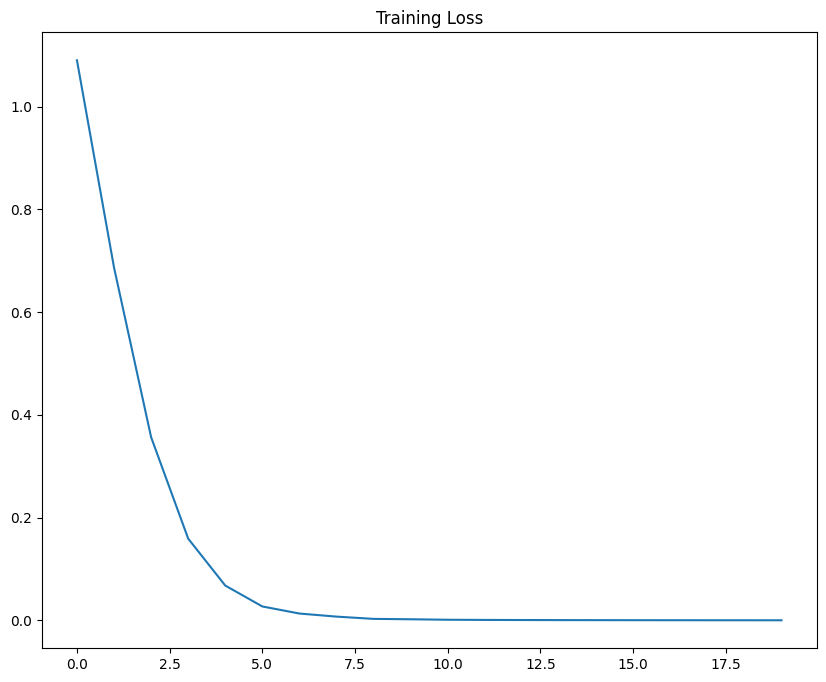

In [12]:
plt.figure(figsize=(10, 8))
plt.plot(losses)
plt.title("Training Loss")
plt.show()

In [13]:
with torch.no_grad():
    x, y = testDataset.tensors[0].cuda(), testDataset.tensors[1].cuda()
    pred = emb_mlp_unfreeze(x)
    count = (pred.argmax(1) == y).sum().float()
    print(f'Acc = {count / len(testDataset) * 100 : 0.3f}%')

Acc =  73.382%


In [14]:
class AttentioBaseModel(torch.nn.Module):

    def __init__(self, train_voc : Vocabulary, preTrainedEmb : np.ndarray, freeze = True) -> None:
        super(AttentioBaseModel, self).__init__()
        self.embeding = torch.nn.Embedding(train_voc.num_words, embedding_dim = preTrainedEmb.shape[1]).from_pretrained(
            embeddings=torch.from_numpy(preTrainedEmb).type(torch.float32),
            freeze=freeze,
            padding_idx=0
            )
        self.selfAtt = torch.nn.MultiheadAttention(300, 1, batch_first = True)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(300, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 2)
        )
    def forward(self, x):
        e = self.embeding(x)
        h_s, atten_score = self.selfAtt(e, e, e)
        h_sum = h_s.sum(dim = 1)
        out = self.mlp(h_sum)
        return out, atten_score

In [15]:
attenModel = AttentioBaseModel(train_voc=train_voc, preTrainedEmb=embeddingMatrix, freeze = False).cuda()
loss_fn = torch.nn.CrossEntropyLoss()
otim = torch.optim.Adam(attenModel.parameters())
losses = []
for ep in tqdm(range(20)):
    total_loss = 0.
    for x, y in trainDataLoader:
        x, y = x.cuda(), y.cuda()
        otim.zero_grad()
        pred, _ = attenModel(x)
        loss = loss_fn(pred, y)
        loss.backward()
        otim.step()
        total_loss += loss.item()
    losses.append(total_loss / (len(testDataset) / 32))

100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


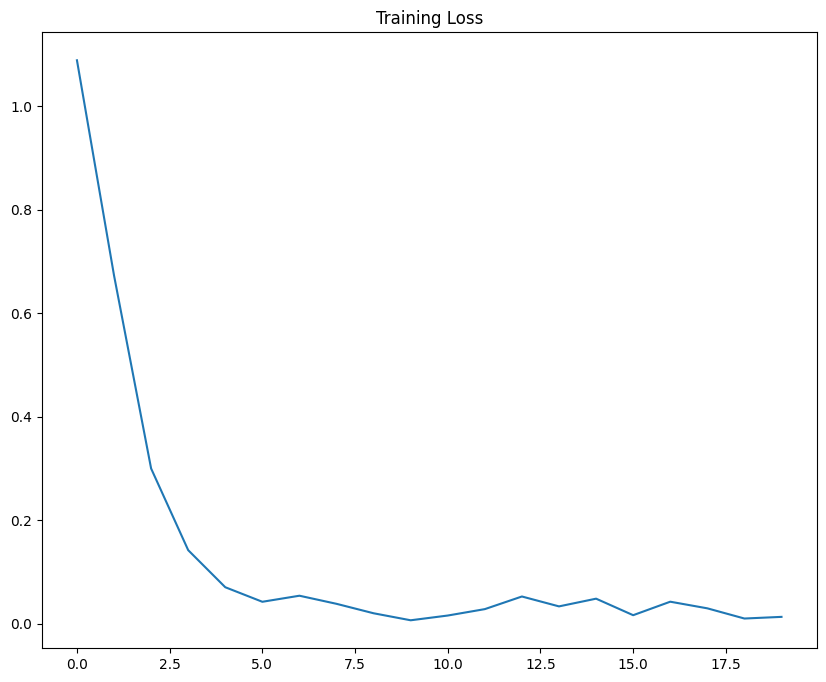

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(losses)
plt.title("Training Loss")
plt.show()

In [17]:
with torch.no_grad():
    x, y = testDataset.tensors[0].cuda(), testDataset.tensors[1].cuda()
    pred, test_atten = attenModel(x)
    count = (pred.argmax(1) == y).sum().float()
    print(f'Acc = {count / len(testDataset) * 100 : 0.3f}%')

Acc =  73.635%


In [18]:
def drawHeatMap(index, atten_score, train_voc : Vocabulary):
    words = [train_voc.idx2word[i.item()] for i in testDataset.tensors[0][index]]
    label = "positive" if testDataset.tensors[1][index].item() == 1 else "negative"
    dataframe = pd.DataFrame(atten_score[index].cpu(), index=words, columns=words)
    plt.figure(figsize=(10, 10))
    sns.heatmap(data = dataframe, linewidths=0.5, vmin=0., vmax=1.)
    plt.title(label=label)
    plt.show()

In [19]:
attenModel_unfreeze = AttentioBaseModel(train_voc=train_voc, preTrainedEmb=embeddingMatrix, freeze = True).cuda()
loss_fn = torch.nn.CrossEntropyLoss()
otim = torch.optim.Adam(attenModel_unfreeze.parameters())
losses = []
for ep in tqdm(range(20)):
    total_loss = 0.
    for x, y in trainDataLoader:
        x, y = x.cuda(), y.cuda()
        otim.zero_grad()
        pred, _ = attenModel_unfreeze(x)
        loss = loss_fn(pred, y)
        loss.backward()
        otim.step()
        total_loss += loss.item()
    losses.append(total_loss / (len(testDataset) / 32))

100%|██████████| 20/20 [00:09<00:00,  2.21it/s]


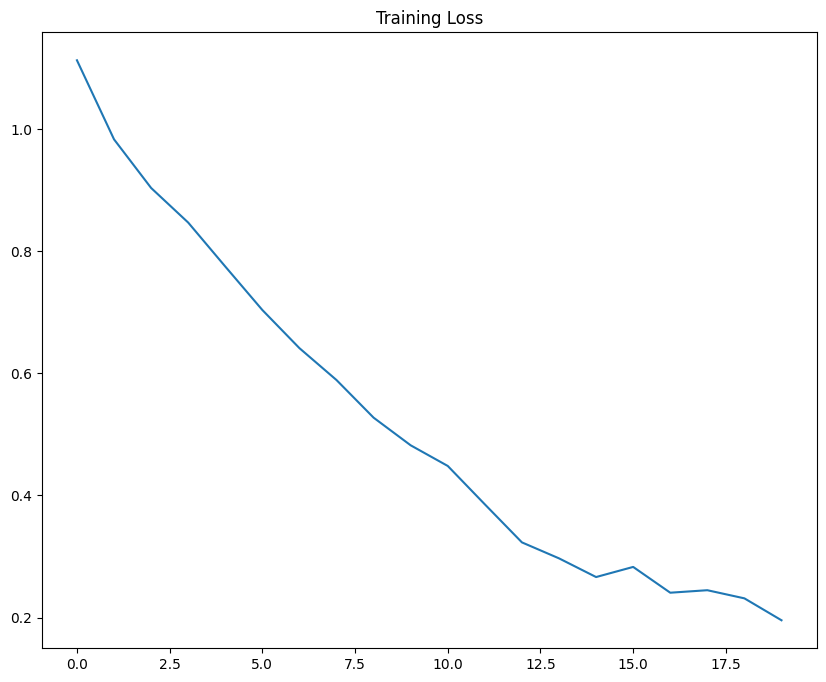

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(losses)
plt.title("Training Loss")
plt.show()

In [21]:
with torch.no_grad():
    x, y = testDataset.tensors[0].cuda(), testDataset.tensors[1].cuda()
    pred, test_atten_unfreeze = attenModel_unfreeze(x)
    count = (pred.argmax(1) == y).sum().float()
    print(f'Acc = {count / len(testDataset) * 100 : 0.3f}%')

Acc =  73.832%


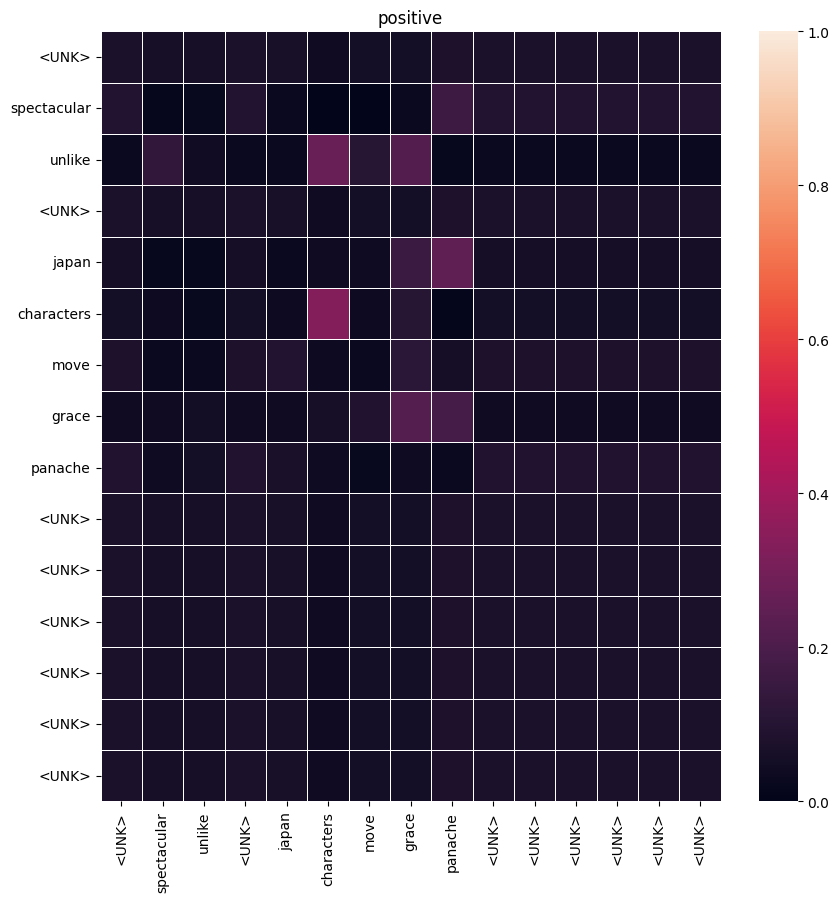

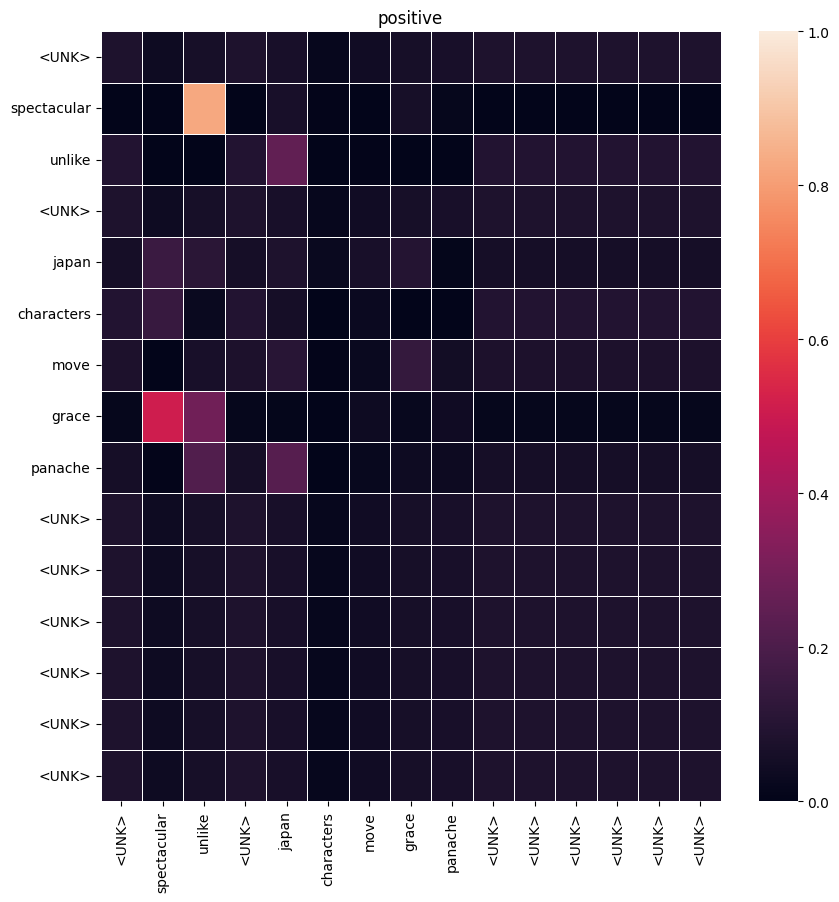

In [24]:
INDEX = 100
drawHeatMap(INDEX, atten_score= test_atten, train_voc = train_voc) # Freeze False
drawHeatMap(INDEX, atten_score= test_atten_unfreeze, train_voc = train_voc) # Freeze True